In [1]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.applications import VGG16,MobileNetV2,InceptionV3
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Dense, Dropout,Flatten,Activation
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
img_rows, img_cols = 224,224
batch_size = 32
classes = 2

In [3]:
train = "/Users/dipit/Road Classification/train"
test = "/Users/dipit/Road Classification/test"

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 25,
                                  zoom_range = 0.2,
                                  shear_range = 0.2,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.2,
                                  fill_mode = "nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(directory=train,
                                                   target_size = (img_rows, img_cols),
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   subset = "training",
                                                   class_mode = "categorical")

Found 559 images belonging to 2 classes.


In [6]:
val_generator = train_datagen.flow_from_directory(directory=train,
                                                   target_size = (img_rows, img_cols),
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   subset = "validation",
                                                   class_mode = "categorical")

Found 138 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(directory=test,
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 shuffle = True,
                                                 class_mode = "categorical")

Found 16 images belonging to 2 classes.


In [8]:
basemodel = MobileNetV2(weights="imagenet",
                    include_top = False,
                    input_shape = (img_rows, img_cols,3))

for layer in basemodel.layers:
    layer.trainable = False

headmodel = Flatten()(basemodel.output)
headmodel = Dense(128, activation="relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(classes,activation="softmax")(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
model.compile(loss="categorical_crossentropy",
             optimizer = "adam",
             metrics = ['acc'])

In [10]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("road_classification_mobilenetv2_1.h5",
                            monitor = "val_acc",
                            mode = "max",
                            save_best_only = True,
                            verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = "val_acc",
                             patience = 2,
                             factor = 0.02,
                             verbose = 1,
                             min_delta = 0.001)

early_stopping = EarlyStopping(monitor="val_acc",
                              min_delta = 0.01,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [11]:
train_samples = 559
val_samples = 138

In [12]:
history = model.fit(train_generator,
                    epochs = 10,
                    steps_per_epoch = train_samples//batch_size,
                    validation_data = val_generator,
                    validation_steps=val_samples//batch_size,
                    callbacks = callbacks)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 3.1754 - acc: 0.8558
Epoch 00001: val_acc improved from -inf to 0.96875, saving model to road_classification_mobilenetv2.h5
17/17 [==============================] - 34s 2s/step - loss: 3.1754 - acc: 0.8558 - val_loss: 1.1023 - val_acc: 0.9688
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.5739 - acc: 0.9222
Epoch 00002: val_acc did not improve from 0.96875
17/17 [==============================] - 35s 2s/step - loss: 1.5739 - acc: 0.9222 - val_loss: 0.4803 - val_acc: 0.9531
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.8814 - acc: 0.9450
Epoch 00003: val_acc did not improve from 0.96875

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
17/17 [==============================] - 35s 2s/step - loss: 0.8814 - acc: 0.9450 - val_loss: 0.3417 - val_acc: 0.9688
Epoch 4/20
17/17 [==============================] - ETA: 0s - loss: 0.3200 - acc: 0.9545
Ep

In [13]:
scores = model.evaluate(val_generator,steps = val_samples//batch_size,verbose=1)
print("Val Accuracy: %.2f Val Loss: %.2f"%(scores[1]*100, scores[0]))

4/4 [==============================] - 5s 1s/step - loss: 0.2618 - acc: 0.9844
Val Accuracy: 98.44 Val Loss: 0.26


In [14]:
val_pred = model.predict(val_generator,steps = val_samples//batch_size,verbose=1)
val_labels = np.argmax(val_pred, axis=1)
val_labels

4/4 [==============================] - 4s 1s/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])

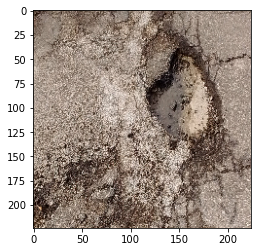

In [21]:
import matplotlib.pyplot as plt
IMG = load_img("/Users/dipit/Road Classification/test/Pothole/8.jpg",target_size=(224, 224))
plt.imshow(IMG)

In [22]:
img = img_to_array(IMG)
img = img/255
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 224, 224, 3)


In [23]:
classes = {
    "TEST":['Plain','Pothole']
}

predictions = model.predict(img)
predictions_c = np.argmax(predictions, axis=1)
print(predictions, predictions_c)

[[1.813706e-28 1.000000e+00]] [1]


In [24]:
predicted_class = classes['TEST'][predictions_c[0]] 
print("This is a road which is {}.".format(predicted_class.lower()))

This is a road which is pothole.


(1, 224, 224, 3)


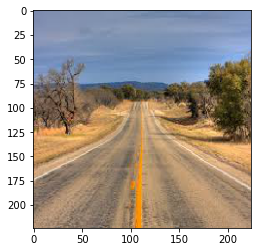

In [25]:
import matplotlib.pyplot as plt
IMG = load_img("/Users/dipit/Road Classification/test/Plain/8.jpg",target_size=(224, 224))
plt.imshow(IMG)
img = img_to_array(IMG)
img = img/255
img = np.expand_dims(img, axis=0)
print(img.shape)

In [26]:
predictions = model.predict(img)
predictions_c = np.argmax(predictions, axis=1)
print(predictions, predictions_c)

[[1.0000000e+00 3.1023675e-27]] [0]


In [27]:
predicted_class = classes['TEST'][predictions_c[0]] 
print("This is a road which is {}.".format(predicted_class.lower()))

This is a road which is plain.
